In [277]:
#from ortools.linear_solver import pywraplp
from ortools.init import pywrapinit
from numpy import linalg as LA
from math import radians, cos, sin, asin, sqrt, dist
from scipy.stats import truncnorm
from ortools.sat.python import cp_model

import numpy as np
import pandas as pd
import geopy.distance
import rvo2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.graph_objects as go
import random


In [278]:
#---------------------------------- EXTRACT THE DATA ----------------------------------

# users-melbcbd-generated.csv contains:
# •  Latitude-Longitude
# of the users in the Melbourne CBD area.
users_path = '..\\eua-dataset\\users\\'
U = pd.read_csv(users_path + 'users-test.csv')

# site-optus-melbCBD.csv contains:
# •  SiteID-Latitude-Longitude-Name-State-LicensingAreaID-PostCode-SitePrecision-Elevation-HCISL2
# of all Optus BS in Melbourne CBD area (edge-servers)
servers_path = '..\\eua-dataset\\edge-servers\\'
S = pd.read_csv(servers_path + 'serverstest_3.csv')

In [279]:
#---------------------------------- VARIABLES ----------------------------------

U_si = [] # Set of individuals allocated to server si

D = (-37.81952,144.95714099999998)  # Danger source position
D_rad = (0.45)/111.139 # Influence range of danger source D (radius) in km

U_per = np.full(len(U),0.2)  # Perception range of individual uj in km
R = np.zeros((4), dtype=int) # R = [CPU, RAM, VRAM, bandwidth]

# User u has memory requirements = w (example for 8 users)
w1 = [1, 2, 1, 2]
w2 = [1, 2,	1, 2]
w3 = [5, 7,	6, 6]
w4 = [2, 3,	3, 4]
w5 = [5, 7,	6, 6]
w6 = [2, 3,	3, 4]
w7 = [1, 2, 1, 2]
w8 = [2, 3,	3, 4]
W = [w1, w2, w3, w4, w5, w6, w7, w8]   
  
# Each server has memory capacity c (example for 3 servers)
c1 = [4, 6, 6, 10]
c2 = [10, 17, 15, 16]
c3 = [10, 15, 11, 15]
C = [c1, c2, c3]   

T_1 =0 # Starting point of period
T_2 = 60 # Ending point of period
T = T_2-T_1 # Total interval time

lambd = 0.5 # Severity of the stimulus event
nej = np.random.uniform(0,1,len(U)) # Emotional fluctuation of uj ---> nej ∈ (0, 1)
se_j =np.random.uniform(0.05,0.1, len(U)) # Individual sensitivity uj 
    


In [280]:
#---------------------------------- RVO Algorithm ----------------------------------
def rvoAlgorithm(U,DangerZone,D_radio,T_interval):
  pref_vel = 5/(111.1*3600)
  sim = rvo2.PyRVOSimulator(1,    #float timeStep
  1.5,    # float MAX neighborDist
                          len(U), # size_t maxNeighbors
                          1,    # float timeHorizon --->  tiempo de respuesta frente la presencia de otros agentes
                          2,      # float timeHorizonObst ---> tiempo de respuesta frente a presencia de obstaculos
                          1,      # float radius ---> of agents
                          pref_vel)      # float maxSpeed ---> of agents
                                  # tuple velocity=(0, 0)
  
  agents =[]
  for j in range(len(U)):
    user_latitude = U.iloc[j]['Latitude']
    user_longitude = U.iloc[j]['Longitude']
    agents.append(sim.addAgent((user_latitude,user_longitude)))

 
  circle_area = [DangerZone[0],DangerZone[1],D_radio]
  circle=[DangerZone[0],DangerZone[1],0.05/111.1]
  xc = circle[0] #x-co of circle (center) 
  xc_area=circle_area[0]
  yc = circle[1] #y-co of circle (center) 
  yc_area= circle_area[1]
  r=circle[2] 
  r_area=circle_area[2]
  t= np.arange(-np.pi,np.pi, 0.1) 
  x_circle= xc + r*np.sin(t) 
  x_circle_area = xc_area+r_area*np.sin(t)
  y_circle= yc + r*np.cos(t) 
  y_circle_area= yc_area + r_area*np.cos(t) 

  # Obstacles are also supported.
  o1 = sim.addObstacle([(xc+r,yc+r), (xc+r,yc-r), (xc-r,yc-r),(xc-r,yc+r)])
  sim.processObstacles()

  
  for a in range(len(agents)):
    #sim.setAgentPrefVelocity(agents[a], (-2,2))
    #sim.setAgentPrefVelocity(agents[a], (random.randint(-10, 10),random.randint(-10, 10)))
    sim.setAgentPrefVelocity(agents[a], (random.uniform(-pref_vel, pref_vel),random.uniform(-pref_vel, pref_vel)))

  #print('Simulation has %i agents and %i obstacle vertices in it.' %
        #(sim.getNumAgents(), sim.getNumObstacleVertices()))
  #print('Running simulation')
 
  positions_T=[]
  fig, ax = plt.subplots(figsize = (10,5))
  

  for step in range(T_interval):
    sim.doStep()

    positions = ['(%5.8f, %5.8f)' % sim.getAgentPosition(agent_no) for agent_no in (agents)]
    velocities = ['(%3.8f, %3.8f)' % sim.getAgentVelocity(agent_no)for agent_no in (agents)]
    
    #print('%s' % ( '  '.join(velocities)))
    #print('step=%2i  t=%.3f  %s' % (step, sim.getGlobalTime(), '  '.join(positions)))
    
    x_p=[]
    y_p=[]
    temp_T=[]

    colors = cm.rainbow(np.linspace(0, 1, len(positions)))
    
    for p in range(len(positions)):
      temp=positions[p]
      temp= temp.replace('(','')
      temp=temp.replace(')','')
      temp=temp.split(',')
      x_p.append(float(temp[0]))
      y_p.append(float(temp[1]))
      temp_T.append([float(temp[0]),float(temp[1])])

      if step==0:
        ax.scatter(float(temp[0]),float(temp[1]),color=colors[p],edgecolor='green', linewidth=2)

      if step==T_interval-1:
        ax.scatter(float(temp[0]),float(temp[1]),color=colors[p],edgecolor='red', linewidth=2)
      
      else:
        ax.scatter(float(temp[0]),float(temp[1]),edgecolors=colors[p],color='white',marker='o')

    positions_T.append(temp_T)
    
  ax.plot(x_circle,y_circle,color='red') 
  ax.plot(x_circle_area,y_circle_area,color='red',alpha=0.3) 
  ax.plot([xc+r,xc+r,xc-r,xc-r,xc+r],[yc+r,yc-r,yc-r,yc+r,yc+r],color='black',linewidth=2)
  ax.plot()
  ax.axis('equal')
  ax.set_title('Location')
  ax.ticklabel_format(useOffset=False)

  return positions_T
  #morado | azul | amarillo | rojo

In [281]:
#---------------------------------- COVERAGE OF EACH SERVER ----------------------------------

def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

for i in range(len(S)):
  server_latitude = S.iloc[i]['LATITUDE']
  server_longitude = S.iloc[i]['LONGITUDE']
  temp = []

  for j in range(len(U)):
    user_latitude = U.iloc[j]['Latitude']
    user_longitude = U.iloc[j]['Longitude']

    radius = 0.03 # In kilometer

    dist_geo = haversine(server_longitude, server_latitude, user_longitude, user_latitude)
    #dist_temp.append(dist_geo)

    if dist_geo <= radius:
        temp.append(1)
        
    else:
        temp.append(0)

  U_si.append(temp)


In [282]:
#---------------------------------- Update position users ----------------------------------

def du_dt_function(timeStep,positions):
    du_Dt=[] # Distance between danger and user
    for j in range(len(U)):
        user_latitude=positions[timeStep][j][0]
        user_longitude=positions[timeStep][j][1]
        user_coordinates = (user_latitude,user_longitude)
        dist_geoDanger = geopy.distance.geodesic(user_coordinates, D).km
        du_Dt.append(dist_geoDanger)
    return du_Dt

In [283]:
#---------------------------------- CRITICALITY MODEL ----------------------------------

def get_truncated_normal(mean, sd, low, upp):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def criticality (time,du_Dt):
    # emj: emotional value
    em_t = np.zeros(len(U))
    for j in range(len(U)):
        if du_Dt[j] < (D_rad+U_per[j]):
            eq = ((time-T_1)/T) * (1-(du_Dt[j]/(D_rad+U_per[j])))*lambd* nej[j]
            em_t[j]=eq
        else:
            em_t[j]=0

    # scrj(t) = sej + emj (t) (subjective criticality equation)
    scr=np.zeros(len(U))
    for j in range(len(U)):
        scr[j]= (se_j[j]+em_t[j])

    ocr_j=np.zeros(len(U)) # ocr objective criticality of individual uj at time step t
    nDiv = 5 # Number of partitions of the coverage area
    circles = D_rad/nDiv # Radius of each circular partition
    covCircles = [] # Distance from the center
    ri = [0.5,0.4,0.3,0.2,0.1]

    for p in range(1,nDiv+1):
        covCircles.append(circles*p)

    for j in range(len(U)):
            if du_Dt[j]<covCircles[0]:
                ocr_j[j] = ri[0]

            elif du_Dt[j]<covCircles[1] and du_Dt[j]>=covCircles[0]:
                ocr_j[j]  =ri[1]

            elif du_Dt[j]<covCircles[2] and du_Dt[j]>=covCircles[1]:
                ocr_j[j]  = ri[2]

            elif du_Dt[j]<covCircles[3] and du_Dt[j]>=covCircles[2]:
                ocr_j[j] = ri[3]
            elif du_Dt[j]<covCircles[4] and du_Dt[j]>=covCircles[3]:
                ocr_j[j]  = ri[4]

            else:
                ocr_j[j]  = 0


    # Criticality equation
    # CRj = (L1 * scrj(t)) + (L2 * ocrj)
    mu=1
    sigma=0.05
    low=0.95
    up =1.05

    X = get_truncated_normal(mu, sigma, low, up)

    #L1 =X.rvs() # weight lambda 1
    L1 = 0.95
    L2 = 1 # weight lambda 2

    # Criticality
    CR = []

    for j in range(len(U)):
        cr = (L1*scr[j])+(L2*ocr_j[j])
        CR.append(cr)

    index_CR=sorted(range(len(CR)), key=lambda a: CR[a],reverse=True)

    return index_CR, CR

In [284]:
#---------------------------------- CP MODEL ----------------------------------
def createModel_t(timeStep,live_positions):
    print(' -------------------------------------------------------------')
    print('Step:  ',timeStep)
    du_dt_temp=du_dt_function(timeStep,live_positions)
    index_CR_t,CR_t =criticality(timeStep,du_dt_temp)

    #---------------------------------- CP MODEL ----------------------------------
    model = cp_model.CpModel()
    #---------------------------------- SOLVER VARIABLES ----------------------------------
    # x_i,j = True if user u_j is allocated to edge server s_i
    # x_i,j = False otherwise
    x = {}
    for j in index_CR_t:
        for i in range(len(S)):
            x[i, j] = model.NewBoolVar(f'c[{i}][{j}]')

    # y_i = True if Sum(xij) > 0, ∀i ∈ {1, . . . , m}
    # y_i = False otherwise
    y = {}
    for i in range(len(S)):
        y[i] = model.NewBoolVar(f'c[{i}]')
               
    #print(model.ModelStats())

    #---------------------------------- CONSTRAINTS ----------------------------------

    # Capacity constraint
    for i in range(len(S)):
        for k in range(len(R)):
            model.Add(
                sum([
                    x[i,j] * W[j][k] for j in index_CR_t
                ]) <= C[i][k]*y[i]
            )
    
    # Each user can be allocated just once
    for j in index_CR_t:
        model.Add(
            sum([
                x[i, j] for i in range(len(S))
            ]) <= 1
        )

    #Coverage
    for j in index_CR_t:
        for i in range(len(S)):
            if U_si[i][j] == 0:
             model.Add(
                x[i, j]==0
             )


    #print(model.ModelStats())

    #---------------------------------- CP SOLVER ----------------------------------
    solver = cp_model.CpSolver()

    #---------------------------------- OBJECTIVE FUNCTIONS ---------------------------------

    # Maximize the number of allocated users
    objective_max = []
    print(CR_t)
    print(sum(CR_t))
    for j in index_CR_t:
        for i in range(len(S)):
            #objective_max.append(cp_model.LinearExpr.WeightedSum(x[i,j], CR_t[j]))
            objective_max.append(x[i, j]*CR_t[j])
    model.Maximize(sum(objective_max))

    solver.Solve(model)
    max_users = solver.ObjectiveValue()

    # Hint (speed up solving)
    for j in index_CR_t:
        for i in range(len(S)):
            model.AddHint(x[i,j], solver.Value(x[i,j]))

    for i in range(len(S)):
        model.AddHint(y[i], solver.Value(y[i]))
        
    # Constraint previous objective
    model.Add(
        sum([
            x[i, j]*CR_t[j] for i in range(len(S)) for j in index_CR_t
        ]) == solver.ObjectiveValue()
    )

    # Minimize the number of servers used
    objective_min = []
    for i in range(len(S)):
        objective_min.append(y[i])
    model.Minimize(sum(objective_min))

    #print(model.ModelStats())

    #---------------------------------- CALL THE SOLVER ----------------------------------
    status = solver.Solve(model)

    #---------------------------------- DISPLAY THE SOLUTION ----------------------------------

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        print('Solution:')
        print(f'Objective value: {max_users} users have been allocated to {solver.ObjectiveValue()} servers\n')
        for j in index_CR_t:
            for i in range(len(S)):
                print(f'User {j} has been allocated on server {i} -->', solver.Value(x[i,j]))
                if int(solver.Value(x[i,j])) == 1:
                    print(f'User {j} has been allocated on server {i}')
    else:
        print('The problem does not have an optimal solution.')
    

 -------------------------------------------------------------
Step:   0
[0.08171870836283865, 0.06989105991331702, 0.08517159560838444, 0.06695316672054386, 0.08397222588489597, 0.07066987744187811, 0.051682630903899865, 0.07565774898271008]
0.5857170138184681


TypeError: Unrecognized linear expression: -0.585717013818468

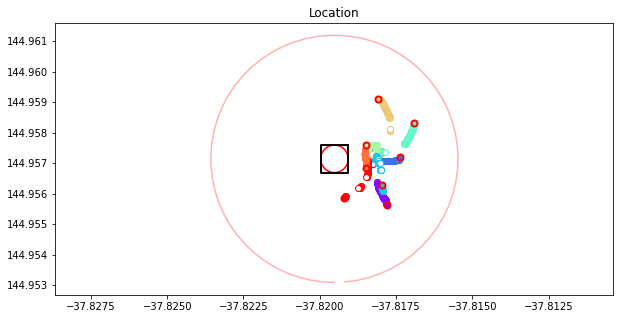

In [285]:
live_positions = rvoAlgorithm(U,D,D_rad,T)
for tt in range(T):
    createModel_t(tt,live_positions)

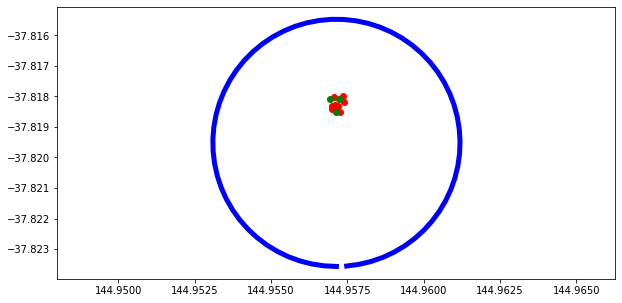

In [ ]:
circle = [D[1],D[0],D_rad]
xc = circle[0] #x-co of circle (center) 

yc = circle[1] #y-co of circle (center) 
r=circle[2] 
t= np.arange(-np.pi,np.pi, 0.1) 
x_circle= xc + r*np.sin(t) 
y_circle= yc + r*np.cos(t)

fig, ax = plt.subplots(figsize = (10,5))

for j in range(len(U)):
        ax.scatter(U['Longitude'][j],U['Latitude'][j],color='red')
        #print('Entro:   ', 'User: ', j)
for i in range(len(S)):
        ax.scatter(S['LONGITUDE'][i],S['LATITUDE'][i],color='green')

ax.plot(x_circle,y_circle,color='blue',linewidth=5)
ax.axis('equal')
#ax.set_xlim(BBox[0],BBox[1])
#ax.set_ylim(BBox[2],BBox[3])
ax.ticklabel_format(useOffset=False)

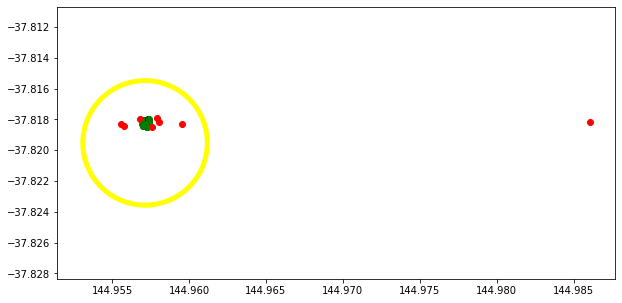

In [ ]:
circle = [D[1],D[0],D_rad]
xc = circle[0] #x-co of circle (center) 

yc = circle[1] #y-co of circle (center) 
r=circle[2] 
t= np.arange(-np.pi,np.pi, 0.1) 
x_circle= xc + r*np.sin(t) 
y_circle= yc + r*np.cos(t)

fig, ax = plt.subplots(figsize = (10,5))

for j in range(len(U)):
        ax.scatter(U['Longitude'][j],U['Latitude'][j],color='black')
        ax.scatter(live_positions[0][j][1],live_positions[0][j][0],color='green')
        ax.scatter(live_positions[T-1][j][1],live_positions[4][j][0],color='red')
        #print('Entro:   ', 'User: ', j)

ax.plot(x_circle,y_circle,color='yellow',linewidth=5)
ax.axis('equal')
ax.ticklabel_format(useOffset=False)